In [3]:
# import modules
import os
from glob import glob
import joblib

import torch
import torch.nn as nn
import torchvision.models as models

from fogvision import gpuutils
from fogvision import fogimageclass

# FogVision image classification models
There are two fogvision inference classification heads one for diurnal and one for nocturnal imagery; both working with resnet50 embeddings

In [4]:
# initialize embedder 
basemodel = models.resnet50(pretrained=True)

num_ftrs = basemodel.fc.in_features
basemodel.fc = nn.Identity()  # Set the classification layer to identity to output embeddings

# choose device
device = gpuutils.get_gpu_most_memory() # if gpus avaible get one with most memory
print(device)

# put the model in evaluation mode
model = basemodel.to(device)
model.eval()


# initialize classification heads (saved from cpu)
if 'cpu' in str(device):
    diurnal_classif_head = torch.load(os.path.join('models', f'fogvision_inference_head_model_diurnal_cpu.pkl'), map_location=device) # NOTE when running model on cpu
    nocturnal_classif_head = torch.load(os.path.join('models', f'fogvision_inference_head_model_nocturnal_cpu.pkl'), map_location=device) # when loading onto cuda
else:
    diurnal_classif_head = joblib.load(os.path.join('models', f'fogvision_inference_head_model_diurnal.pkl')) # NOTE when loading onto cuda
    nocturnal_classif_head = joblib.load(os.path.join('models', f'fogvision_inference_head_model_nocturnal.pkl')) 



cuda:0


# FogVision image classification
The fog image class can be used to classify images (as shown below). Given the image filepath, the embedding mode and the classification head model. If the image [center] is gray scale the nocturnal model will be used.

In [45]:
# get a list of filenames for a given day
from datetime import datetime
data_dir = r'C:\Users\jnicolow\Documents\research\fog\training_data\waiopai'

file_names = glob(os.path.join(data_dir, '*', '*', '*.jpg'))

target_date = "2022-05-19"
# target_date = "2022-05-20"
# target_date = "2022-05-21"
# target_date = "2022-05-22"
# target_date = "2022-05-23"

dates = ["2022-05-19", "2022-05-20", "2022-05-21", "2022-05-22", "2022-05-23"]
dates = ["2022-05-20"]

all_image_fns = []
for target_date in dates:
    image_fns = [f for f in file_names if target_date in f]

    files_on_date_sorted = sorted(
        image_fns,
        key=lambda f: datetime.strptime(os.path.basename(f).split('_')[1] + "_" + os.path.basename(f).split('_')[2].split('.')[0],
                                        "%Y-%m-%d_%H%M%S")
    )
    all_image_fns.extend(image_fns)
    print(len(image_fns))
    
    
image_fns = all_image_fns
print(f'there are {len(image_fns)} total from {len(dates)} days')

96
there are 96 total from 1 days


Image saved to media\example_images\waiopai\waiopai_2022-05-20_053550.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_055051.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_060553.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_062054.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_063555.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_072059.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_075102.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_080603.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_065057.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_070558.jpg.png
Image saved to media\example_images\waiopai\waiopai_2022-05-20_073601.jpg.png


KeyboardInterrupt: 

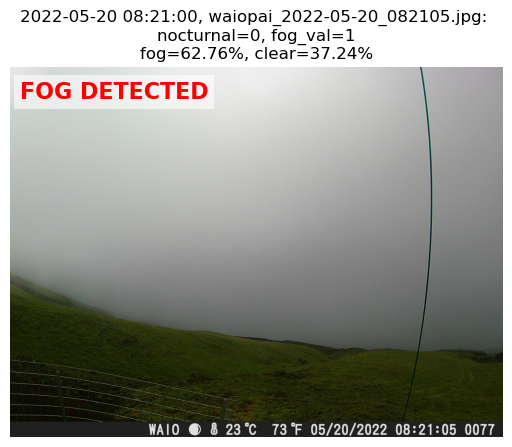

In [46]:
import importlib
importlib.reload(fogimageclass)
# image_fns = glob(os.path.join('data', 'images', '*.jpg')) # NOTE use the ones selected above

crop_size = None # if crop size is None then it will take largest crop possible

for fn in image_fns:
    fog_img_class = fogimageclass.FogImage(filepath=fn, crop_size=crop_size)
    if fog_img_class.nocturnal:
        fog_img_class.get_fog_val(model=nocturnal_classif_head, embedding_model=basemodel, random_crop=False) # NOTE only takes image embedding from 
        # fog_img_class.get_fog_val_multiple_regions(model=nocturnal_classif_head, embedding_model=basemodel) # NOTE not ideal for images with a lot of open sky works best on forested environments
    else:
        fog_img_class.get_fog_val(model=diurnal_classif_head, embedding_model=basemodel, random_crop=False)
        # fog_img_class.get_fog_val_multiple_regions(model=diurnal_classif_head, embedding_model=basemodel)
    # if fog_img_class.fog_val == 0: continue
    fog_img_class.plot_image(plot_crop=False, save_path=os.path.join('media', 'example_images', 'waiopai', f'{os.path.basename(fn)}.png')) # plot image with nocturnal and fog value
    # break


In [41]:
import imageio

# List of image filenames (make sure they are in order)
filenames = glob(os.path.join('media', 'example_images', 'waiopai', '*.png'))

with imageio.get_writer(os.path.join('media', 'fog_timelapse_animation.gif'), mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF saved as 'media/fog_timelapse_animation.gif'")

C:\Users\jnicolow\AppData\Local\Temp\ipykernel_23584\526861735.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'media/fog_timelapse_animation.gif'
